## Packages

In [20]:
import astropy.units as u
import astropy.constants as const
import scipy.integrate as integ
import scipy
import scipy.interpolate as interp
import scipy.optimize as opt
import collections
import h5py
import mystats

from myplt import *

In [42]:
class Units:
    def __init__(self, 
                 ulength=u.kpc.to('cm'), 
                 umass=u.Msun.to('g')*1.0e10, uvel=1.0e5):
        self.uL = ulength * u.cm
        self.uM = umass * u.g
        self.uV = uvel * u.cm / u.s
        self.uT = self.uL / self.uV
        print( 'units: L=%s, M=%s, V=%s, T=%s'%( self.uL, self.uM, self.uV, self.uT ) )
        self._get_const()
    def __getitem__(self, tag):
        return self.consts[tag]
    def _get_const(self):
        self.consts = {
            'G': (const.G / ( self.uL**3 / self.uT**2 / self.uM ) ).to(1).value,
            'Msun': ( u.Msun/self.uM ).to(1)
        }
        print('consts:', ', '.join([ '%s=%s'%(k,v) for k,v in self.consts.items()]) )
units = Units()
        
class CoordsCvt:
    def __init__(self):
        pass
    
    @staticmethod
    def sphere_to_cart(theta, phi):
        return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    
class RNG:
    def __init__(self):
        pass
    @staticmethod
    def sphere( n ):
        cos_t = 2*RNG.uniform(n)-1.0
        t = np.arccos( cos_t )
        phi = 2.0*np.pi*RNG.uniform(n)
        return CoordsCvt.sphere_to_cart( t, phi ).T
    @staticmethod
    def uniform( n, lo=0., hi=1. ):
        return np.random.uniform( low = lo, high=hi, size=n )

def IC_generator(filename, x, v, mass):
    npart = len(x)
    attrs = {
        'BoxSize': 0., 'Flag_Cooling': 0,
        'Flag_Entropy_ICs': np.array([0]*6, dtype=int),
        'Flag_Feedback': 0,
        'Flag_Metals': 0,
        'Flag_Sfr': 0,
        'Flag_StellarAge': 0,
        'HubbleParam': 1.0,
        'MassTable': np.array([0., mass, 0., 0., 0., 0.], dtype=float),
        'NumFilesPerSnapshot': 1,
        'NumPart_ThisFile': np.array([0, npart, 0, 0, 0, 0], dtype=int),
        'NumPart_Total': np.array([0, npart, 0, 0, 0, 0], dtype=int),
        'NumPart_Total_HighWord': np.array([0]*6, dtype=int),
        'Omega0': 0.,
        'OmegaLambda': 0.,
        'Redshift': 0.,
        'Time': 0.
    }
    dsets = {
        'Coordinates': x,
        'Velocities': v,
        'ParticleIDs': np.arange(npart, dtype=int)
    }
    
    f = h5py.File( filename, 'w' )
    h = f.create_group('Header')
    a = h.attrs
    for k, v in attrs.items():
        a.create(k, data=v)
    g = f.create_group('PartType1')
    for k, v in dsets.items():
        g.create_dataset(k, data=v)

units: L=3.085677581467192e+21 cm, M=1.988409870698051e+43 g, V=100000.0 cm / s, T=3.085677581467192e+16 s
consts: G=43009.17270069977, Msun=1e-10


## Density Profile

In [26]:
class DensProfile:
    def __init__(self):
        self.rt, self.r0, self.mass = 0., 0., 0.
    def rho(self, r):
        pass
    def M(self, r):
        pass
    def V(self, r):
        pass
    def sigma(self, r):
        pass
    def r_at_M(self, M):
        return
    
class NFWProfile(DensProfile):
    def __init__(self, mass, rs, rt=None, rw=None, r0=None, units=None ):
        self.mass = mass
        self.rs = rs
        self.rt = rt if rt else 15.0*rs
        self.rw = rw if rw else rs
        self.r0 = r0 if r0 else 1.0e-5 * rs
        
        self.xs, self.xt, self.xw, self.x0 = 1.0, \
            self.rt/self.rs, self.rw/self.rs, self.r0 / self.rs
        self.ys, self.yt, self.yw, self.y0 = 0., \
            np.log( self.xt ), np.log( self.xw ), np.log( self.x0 )
        self.vols = 4.0/3.0*np.pi*rs*rs*rs
        
        self.units = units if units else Units()
        self.G =  self.units['G']
        
        self._interp_IM()
        self._interp_IV()
        self._interp_Isigma()
        
        # self._interp_IE_at_E()
    def rho(self, r):
        return self.rho0 * self._Irho( r/self.rs )
    def M(self, r):
        return 3.0*self.Ms*self._IM( r/self.rs )
    def V(self, r):
        return self.V0 + 3.0 * self.Vs * self._IV( r/self.rs )
    def sigma2(self, r):
        x = r/self.rs
        return 3.0*self.Vs/self._Irho(x)*self._Isigma(x)

    def r_at_M(self, M):
        return self._inv_IM( M/(3.0*self.Ms) ) * self.rs
    
    def _Irho(self, x):
        xp1 = 1.0+x
        return 1.0 / ( x*xp1*xp1 ) * scipy.special.erf( (self.xt-x)/self.xw )
    def _Irhoy(self, y):
        return self._Irho( np.exp(y) )
    def _interp_IM(self):
        Irhoy = self._Irhoy
        def f( y ):
            return np.exp( 3.0*y ) * Irhoy(y)
        y1, y2 = self.y0, self.yt
        ys = np.linspace( y1, y2, 1500 )
        IMys = [ integ.quad( f, y1, y )[0] for y in ys ]
        _IMy = mystats.InterpBound( ys[0], ys[-1], interp.interp1d(ys, IMys, 'cubic') )
        self._IMy = _IMy
        self._IM = lambda x: _IMy( np.log(x) )
        self.Ms = self.mass / (3.0*IMys[-1])
        self.rho0 = self.Ms / self.vols
        self.Vs = self.G * self.Ms / self.rs
        print('interp for M done, IM = [%f...%f]'%( IMys[0], IMys[-1] ))
        _inv_IMy = mystats.InterpBound( IMys[0], IMys[-1], interp.interp1d(IMys, ys, 'cubic') )
        self._inv_IMy = _inv_IMy
        self._inv_IM = lambda IM: np.exp(_inv_IMy(IM) )
    def _interp_IV(self):
        IMy = self._IMy
        def f( y ):
            return IMy(y) / np.exp(y)
        y1, y2 = self.y0, self.yt
        ys = np.linspace( y1, y2, 1500 )
        IVys = [ integ.quad( f, y1, y )[0] for y in ys ]
        _IVy = mystats.InterpBound( ys[0], ys[-1], interp.interp1d(ys, IVys, 'cubic') )
        self._IVy = _IVy
        self._IV = lambda x: _IVy( np.log(x) )
        self.V0 = -3.0*self.Vs*IVys[-1]
        print('interp for V done, IV = [%f...%f]'%( IVys[0], IVys[-1] ))
    def _interp_Isigma(self):
        IMy, Irhoy = self._IMy, self._Irhoy
        def f(y):
            return IMy(y)*Irhoy(y) / np.exp(y)
        y1, y2 = self.y0, self.yt
        ys = np.linspace( y1, y2, 1500 )
        Isigmays = [ integ.quad( f, y, y2 )[0] for y in ys ]
        _Isigmay = mystats.InterpBound( ys[0], ys[-1], interp.interp1d(ys, Isigmays, 'cubic') )
        self._Isigmay = _Isigmay
        self._Isigma = lambda x: _Isigmay( np.log(x) )
        print('interp for sigma done, Isigma = [%f...%f]'%( Isigmays[0], Isigmays[-1] ))
'''
    def rho_at_r(self, r):
        return self.rho0 * self._Irho_at_x(r/self.rs)
    def M_at_r(self, r):
        rs = self.rs
        return self.rho0 * 4.0 * np.pi * rs*rs*rs * self._IM_at_x( r/self.rs )
    def r_at_M(self, M):
        rs = self.rs
        return self._x_at_IM( M / ( self.rho0 * 4.0 * np.pi * rs*rs*rs ) ) * self.rs
    def V_at_r(self, r):
        G = self.units['G']
        rs = self.rs
        norm = G * 4.0 * np.pi * rs*rs * self.rho0
        return - norm * self._IVV_at_x(r/self.rs)
        #- G * self.M_at_r(r) / (r + 1.0e-10) \
        #    - norm * self._IV_at_x(r/self.rs) - self.V0
    def sigma2_at_r(self, r):
        norm = 4.0 * np.pi * self.units['G'] * self.rho0 * self.rs * self.rs
        x = r / self.rs
        return np.abs( self._Isigma2_at_x( x )*norm )
    def fE_at_E(self, E):
        norm = 1.0/( 4.0*np.pi*self.rs*self.rs*self.units['G'] ) * 2.0 / ( np.sqrt(8.)*np.pi*np.pi )
        return -norm*self._IE_at_E(E)
    def _interp_Irho_at_x(self):
        rs_ov_w, rT_ov_rs = self.rs_over_w, self.rT_over_rs
        def f(x):
            return 1.0 / (x * (1.0+x) * (1.0+x)) * \
                scipy.special.erf( rs_ov_w * (rT_ov_rs - x) )
        self._Irho_at_x = mystats.InterpBound(0.01, self.rT_over_rs, f)
    def _interp_IM_at_x(self):
        rs_ov_w, rT_ov_rs = self.rs_over_w, self.rT_over_rs
        def f(x):
            return x / ((1.0+x)*(1.0+x)) * scipy.special.erf( rs_ov_w*(rT_ov_rs-x) )
        xs = np.arange( 0., self.rT_over_rs+0.01+1.0e-6, 0.01, dtype=float )
        ys = np.array( [ integ.quad( f, 0., x )[0] for x in xs ] )
        self._IM_at_x = mystats.InterpBound( 1.0e-2, self.rT_over_rs, interp.interp1d( xs, ys, 'slinear' ) ) 
        self._x_at_IM = mystats.InterpBound( ys[0], ys[-1], interp.interp1d( ys, xs, 'slinear' ) )  
        print('interpolate for IM(x) done, no. points=', len(xs) )
    def _interp_IV_at_x(self):
        Irho_at_x = self._Irho_at_x
        def f(x):
            return Irho_at_x(x)*x
        xs = np.arange( 0.01, self.rT_over_rs+1.0e-6, 0.01, dtype=float )
        ys = np.array( [ integ.quad( f, x, self.rT_over_rs, epsabs=1.0e-5, epsrel=1.0e-5 )[0] for x in xs ] )
        yss = ys + self._IM_at_x(xs) / xs - self._IM_at_x(self.rT_over_rs) / self.rT_over_rs
        self._IV_at_x = mystats.InterpBound( 1.0e-2, self.rT_over_rs, interp.interp1d( xs, ys, 'slinear' ) )  
        self._IVV_at_x = mystats.InterpBound( 1.0e-2, self.rT_over_rs, interp.interp1d( xs, yss, 'slinear' ) )  
        self._x_at_IVV = mystats.InterpBound( yss[-1], yss[0], interp.interp1d( yss[::-1], xs[::-1], 'slinear' ) )  
        print('interpolate for IV(x) done, no. points=', len(xs) )
    def _interp_Isigma2_at_x(self):
        Irho_at_x = self._Irho_at_x
        IM_at_x = self._IM_at_x
        def f(x):
            return IM_at_x(x) * Irho_at_x(x) / x*x
        xs = np.arange( 0.01, self.rT_over_rs-1.0e-6, 0.01, dtype=float )
        ys = np.array( [ integ.quad( f, x, self.rT_over_rs, epsabs=1.0e-5, epsrel=1.0e-5 )[0] / Irho_at_x(x) for x in xs ] )
        self._Isigma2_at_x = mystats.InterpBound( xs[0], xs[-1], interp.interp1d( xs, ys, 'slinear' ) )
        print('interpolate for Isigma(x) done, no. points=', len(xs) )
    def _interp_IE_at_E(self):
        Irho_at_x = self._Irho_at_x
        IVV_at_x = self._IVV_at_x
        def I_drhodV_at_x( x ):
            x1, x2 = x-1.0e-3, x+1.0e-3
            Irho1, Irho2 = Irho_at_x(x1), Irho_at_x(x2)
            IVV1, IVV2 = IVV_at_x(x1), IVV_at_x(x2)
            return (Irho2-Irho1)/(IVV2-IVV1)
        x_at_IVV = self._x_at_IVV
        norm = self.units['G'] * 4.0 * np.pi * self.rho0 * self.rs * self.rs
        def I_drhodV_at_y( y, E ):
            V = E + y*y
            x = x_at_IVV( V / (-norm)  )
            return I_drhodV_at_x(x)
        E_min, E_max = self.V_at_r(0.), self.V_at_r(self.rT) 
        E_span = E_max-E_min
        Es = np.linspace( E_min+E_span*1.0e-2, E_max-E_span*1.0e-2, 10 )  # change here for large bins
        fEEs = np.array( [ integ.quad( lambda y: I_drhodV_at_y(y, E), \
                    0., np.sqrt(E_max-E), epsabs=1.0e-3, epsrel=1.0e-3 )[0]  for E in Es ] )
        fEE_at_E = mystats.InterpBound( Es[0], Es[-1], interp.interp1d( Es, fEEs, 'slinear' ) )
        def IE_at_E(E):
            h = (E_max - E_min)/10000.0
            E1, E2 = fEE_at_E(E-h), fEE_at_E(E+h)
            return (E2-E1)/(2.0*h)
        self._IE_at_E = IE_at_E
        print('interpolate for IE(E) done, no. points=', len(Es) )
'''

"\n    def rho_at_r(self, r):\n        return self.rho0 * self._Irho_at_x(r/self.rs)\n    def M_at_r(self, r):\n        rs = self.rs\n        return self.rho0 * 4.0 * np.pi * rs*rs*rs * self._IM_at_x( r/self.rs )\n    def r_at_M(self, M):\n        rs = self.rs\n        return self._x_at_IM( M / ( self.rho0 * 4.0 * np.pi * rs*rs*rs ) ) * self.rs\n    def V_at_r(self, r):\n        G = self.units['G']\n        rs = self.rs\n        norm = G * 4.0 * np.pi * rs*rs * self.rho0\n        return - norm * self._IVV_at_x(r/self.rs)\n        #- G * self.M_at_r(r) / (r + 1.0e-10)         #    - norm * self._IV_at_x(r/self.rs) - self.V0\n    def sigma2_at_r(self, r):\n        norm = 4.0 * np.pi * self.units['G'] * self.rho0 * self.rs * self.rs\n        x = r / self.rs\n        return np.abs( self._Isigma2_at_x( x )*norm )\n    def fE_at_E(self, E):\n        norm = 1.0/( 4.0*np.pi*self.rs*self.rs*self.units['G'] ) * 2.0 / ( np.sqrt(8.)*np.pi*np.pi )\n        return -norm*self._IE_at_E(E)\n    def _in

In [27]:
totmass = 1.0e2
rs = 10.0
nfw = NFWProfile(totmass, rs)

units: L=3.085677581467192e+21 cm, M=1.988409870698051e+43 g, V=100000.0 cm / s, T=3.085677581467192e+16 s
consts: G=43009.17270069977, Msun=1e-10
interp for M done, IM = [0.000000...1.801137]
interp for V done, IV = [0.000000...0.815079]
interp for sigma done, Isigma = [4.691284...0.000000]


## IC with Jeans Equation 

In [1]:
class JeansIC:
    def __init__(self, profile):
        self.profile = profile
        self.r0, self.rt = profile.r0, profile.rt
        self.mass = profile.mass
    def get(self, n):
        M = RNG.uniform( n ) * self.mass
        r = self.profile.r_at_M( M )
        sigma = np.sqrt(self.profile.sigma2( r ))
        
        pos = RNG.sphere(n) * r.reshape(n,1)
        vel = np.random.randn(n, 3)*sigma * r.reshape(n,1)
        vel = vel - vel.mean( axis=0 )
        
        partmass = self.mass / n
        
        return pos, vel, partmass

In [2]:
n = 100000
pos, vel, m = jeans = JeansIC( nfw ).get(n)

NameError: name 'nfw' is not defined

In [447]:
sigma.max()


1033.0288006966803

In [448]:
Nsample = 100000

Ri = np.random.uniform( size=Nsample, low=1.0e-3, high=0.9999 )
rmax = nfw.rmax()
r = nfw.r_at_M( Ri * nfw.M_at_r( rmax ) )
pos = rng_sphere( Nsample ) * r.reshape((Nsample,-1))

sigma = np.sqrt(nfw.sigma2_at_r( r ))
vel = np.random.randn(Nsample, 3) * sigma.reshape((Nsample, -1))

partmass = totmass / Nsample

In [226]:
IC_generator( 'run_jeans_eq/IC.hdf5', pos, vel, partmass )

In [450]:
v_norm = np.sqrt(np.sum(vel*vel, axis=1))

In [451]:
np.quantile( v_norm, [.1, .3, .5, .7, .9, 1.] )

array([ 320.6053231 ,  662.08950832,  995.84593126, 1391.58576698,
       2030.99792459, 4809.01677112])

In [441]:
np.sqrt( nfw.sigma2_at_r(50) )

846.6768379910612

## IC with Eddington Inversion

In [356]:
class EddInv:
    def __init__(self, prof):
        self.prof = prof
        self.rmax = prof.rmax()
        self.mass_max = prof.M_at_r(self.rmax)
        self.ET = prof.V_at_r(self.rmax)
        
        self.f_optimize_target = lambda x,y: 1.5*x - 0.5*x*x*x - y
    def vmax(self, V):
        return np.sqrt( 2.0*(self.ET-V) )
    def one_sample(self):
        R0, R1, R2, R3 = np.random.uniform( size=4 )
        r = self.prof.r_at_M( R0 * self.mass_max )
        V = self.prof.V_at_r(r)
        vmax = self.vmax(V)
        
        z = np.sqrt(R1)
        vr = opt.root_scalar( self.f_optimize_target, args=(R2,), bracket=[0., 1.], method='brentq' ).root * vmax
        vr2 = vr*vr
        vmax2 = vmax*vmax
        vt2 = z*z*( vmax2-vr2 )        
        fs = self.prof.fE_at_E( [ (vr2+vt2)/2.0+V, V ] )
        reject_thres = fs[0] / fs[1]
        if R3 > reject_thres: return None
        
        vt = np.sqrt(vt2)
        return r, vr, vt
    def samples( self, size ):
        s = []
        cnt = 0
        while len(s) < size:
            sample = self.one_sample()
            cnt += 1
            if sample: s.append(sample)
        print('sampling rate = ', size/cnt)
        r, vr, vt = np.array(s).T
        pos = rng_sphere( size ) * r.reshape((size,-1))
        
        rn = np.random.randint(0, 2, size=size)
        rn[ rn == 0 ] = -1
        vr = vr*rn
        
        phi = 2.0*np.pi*np.random.uniform(size=size)
        vx = np.cos(phi) * vt
        vy = np.sin(phi) * vt
        vz = vr
        vel = np.array([vx,vy,vz]).T
        print('range: pos=', np.max( np.abs(pos) ), ', vel=', np.max(np.abs(vel)))
        return pos, vel

In [357]:
eddinv = EddInv(nfw)

In [364]:
Nsample = 100000
pos, vel = eddinv.samples(Nsample)
partmass = totmass/Nsample
IC_generator( 'run_eddington_inv/IC.hdf5', pos, vel, partmass )

/home/yangyao/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/yangyao/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


sampling rate =  0.2341701011614837
range: pos= 148.77334214300228 , vel= 583.3915658323709


## Measure the Equilibrium

In [549]:
class DumpedSet:
    def __init__(self, fname):
        f = h5py.File(fname, 'r')
        pos = np.array(f['PartType1/Coordinates'])
        vel = np.array(f['PartType1/Velocities'])
        V = np.array(f['PartType1/Potential'])
        t = f['Header'].attrs['Time']
        npart = f['Header'].attrs['NumPart_ThisFile'][1]
        
        T = np.sum(vel * vel, axis=1) / 2.0
        r = np.sqrt(np.sum(pos * pos, axis=1))
        
        virial_ratio = -2.0 * T.sum() / ( V.sum()*0.5 )
        q = (.1, .25, .5, .75, .9, .98)
        r_quantile = np.quantile( r, q )
        E = T.sum() + V.sum()*0.5
        
        COM = pos.mean(axis=0)
        pos_rel = pos - COM
        r_COM = np.sqrt( np.sum(COM*COM) )
        
        vel_COM = vel.mean(axis=0)
        vel_rel = vel - vel_COM
        v_COM = np.sqrt( np.sum(vel_COM*vel_COM) )
        
        L = np.cross( pos_rel, vel_rel ).sum( axis=0 )
        L_COM = np.sqrt( np.sum(L*L) )
        
        
        self.stats = {'-2T/V': virial_ratio, 'q': q, 'r_quantile': r_quantile, 'E': E, 't':t, 'npart': npart, 'r_COM': r_COM, 'v_COM': v_COM, 'L_COM': L_COM}
    def get_stats(self, tag):
        return self.stats[tag]
    
class DumpedSets:
    def __init__(self, fbase, nfiles, rs = 10.0, units = Units()):
        ts = []
        Es = []
        qs = []
        r_quantiles = []
        virial_ratios = []
        xs = []
        vs = []
        Ls = []
        npart = None
        for i in range(12):
            d = DumpedSet(fbase + '/snapshot_%.3d.hdf5'%i)
            t, E, q, r_q, virial = d.stats['t'], d.stats['E'], d.stats['q'], d.stats['r_quantile'], d.stats['-2T/V']
            x, v, L = d.stats['r_COM'], d.stats['v_COM'], d.stats['L_COM']
            ts.append( (t*units.uT/u.Gyr).to(1).value )
            Es.append(E)
            qs.append(q)
            r_quantiles.append(r_q / rs)
            virial_ratios.append(virial)
            xs.append(x)
            vs.append(v)
            Ls.append(L)
            npart = d.stats['npart']
        self.stats = {'-2T/V': virial_ratios, 'q': qs, 'r_quantile': r_quantiles, 'E': Es, 't':ts, 'npart':npart, 'x': xs, 'v':vs, 'L':Ls}

units: L=3.085677581467192e+21 cm, M=1.988409870698051e+43 g, V=100000.0 cm / s, T=3.085677581467192e+16 s
consts: G=43009.17270069977, Msun=1e-10


In [550]:
dsets_jeans = DumpedSets('./run_jeans_eq/output/', 12).stats
dsets_edd = DumpedSets('./run_eddington_inv/output/', 12).stats

In [545]:
np.cross([[1,2,3], [4,5,6]], [[1,2,3], [4,5,6]])

array([[0, 0, 0],
       [0, 0, 0]])

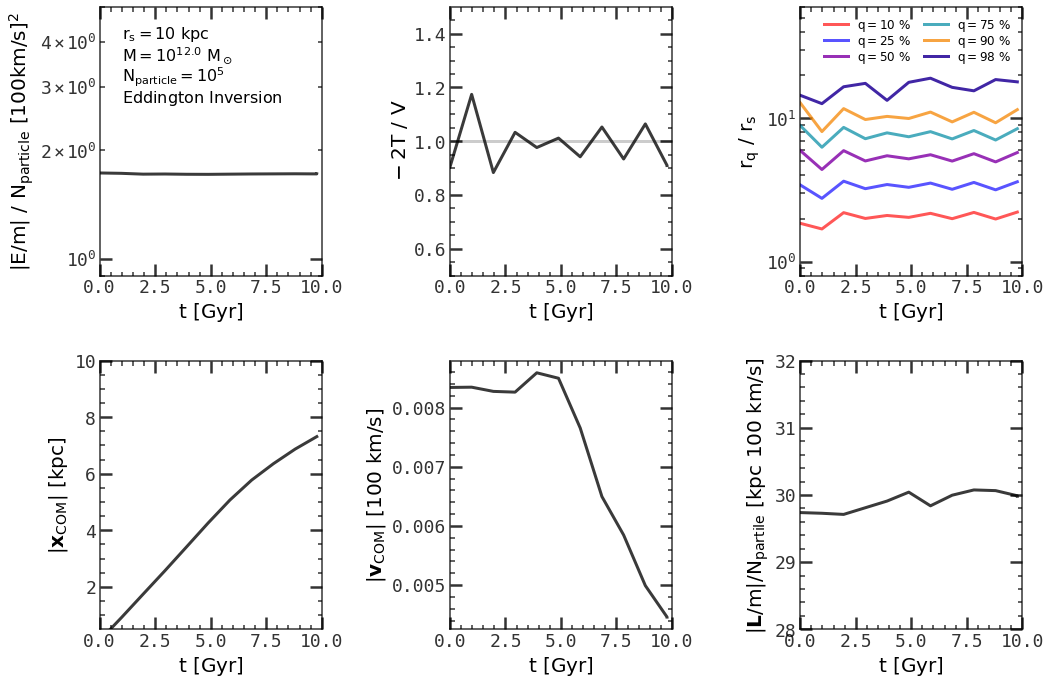

In [573]:
_, axs = m_get_figure((15,10),2,3)
axs = axs[0] + axs[1]

Nsamples = dsets_edd['npart']

ax = axs[0]
#ax.plot( dsets_jeans['t'], dsets_jeans['E']/Nsamples, c=mycms2[0] )
ax.plot( dsets_edd['t'], np.abs(dsets_edd['E'])/Nsamples/10000, c=mycms2[-1] )
m_set_lim(ax, [0., 10] ,[0.9, 5.])
m_set_scale(ax, y='log')
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |E/m|\ /\ N_{particle}\ [100 km/s]^2$')
txposs( ax, [r'$\rm r_s=10\ kpc$', r'$\rm M=10^{12.0}\ M_\odot$', r'$\rm N_{particle}=10^5$', r'$\rm Eddington\ Inversion$'], (.1, .9), (0. -.08), 'k' )

ax = axs[1]
ax.plot( dsets_edd['t'], dsets_edd['-2T/V'], c=mycms2[-1] )
ax.plot( [0., 10.], [1.0, 1.0], c=[0,0,0,.2], lw=3. )
m_set_lim(ax,  [0., 10], [0.5, 1.5])
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm -2T\ /\ V$')

ax = axs[2]
qs = dsets_edd['q'][0]
ts = dsets_edd['t']
r_qs = np.array(dsets_edd['r_quantile']).T
for i, r_q in enumerate(r_qs):
    ax.plot( ts, r_q, c=mycms2[i], label=r'$\rm q = %.0f\ \%%$'%( qs[i]*100 ) )
ax.legend(loc='best', ncol=2, labelspacing=0, columnspacing=1., frameon=False, fontsize=12)
m_set_lim(ax,  [0., 10], [0.8, 60.0])
m_set_scale(ax, y='log')
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm r_{q}\ /\ r_s $')

ax = axs[3]
ax.plot( dsets_edd['t'], dsets_edd['x'], c=mycms2[-1] )
m_set_lim(ax,  [0., 10], [0.5, 10.0])
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf x}_{COM}|\ [kpc]$')

ax = axs[4]
ax.plot( dsets_edd['t'], np.array(dsets_edd['v'])/100.0, c=mycms2[-1] )
m_set_lim(ax,  [0., 10])
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf v}_{COM}|\ [100\ km/s]$')

ax = axs[5]
ax.plot( dsets_edd['t'], np.array(dsets_edd['L'])/Nsamples, c=mycms2[-1] )
m_set_lim(ax,  [0., 10], [28, 32])
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf L}/m|/N_{partile}\ [kpc\ 100\ km/s]$')

plt.tight_layout()
plt.savefig('measure_stats.pdf')
plt.show()

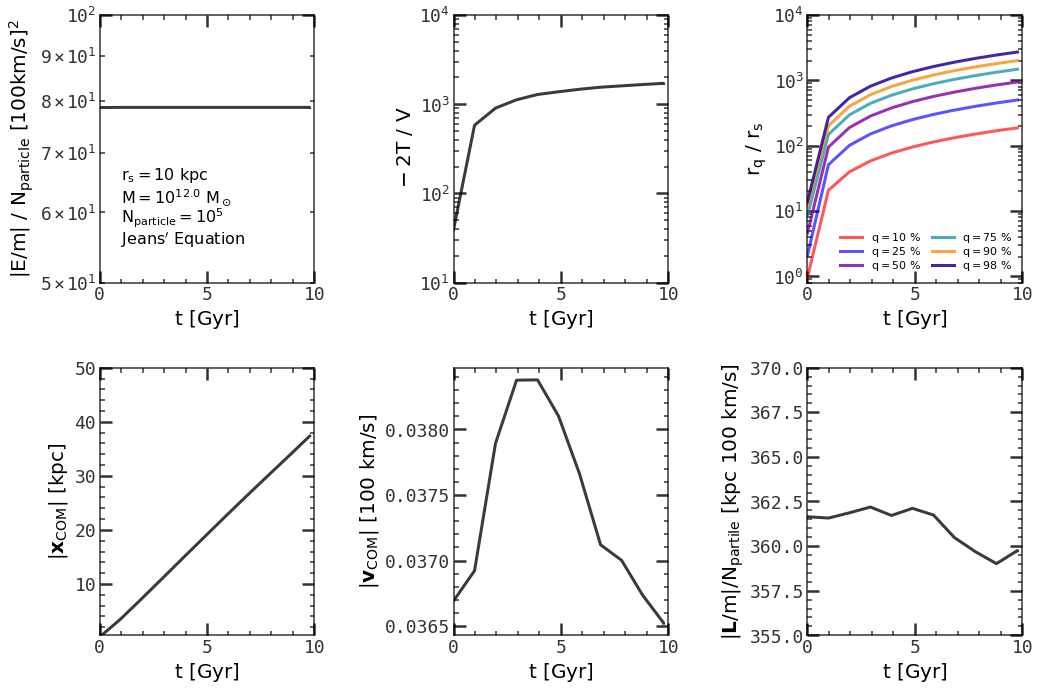

In [581]:
_, axs = m_get_figure((15,10),2,3)
axs = axs[0] + axs[1]

dset = dsets_jeans
Nsamples = dset['npart']

ax = axs[0]
ax.plot( dsets_edd['t'], np.abs(dset['E'])/Nsamples/10000, c=mycms2[-1] )
m_set_lim(ax, [0., 10], [50, 100] )
m_set_scale(ax, y='log')
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |E/m|\ /\ N_{particle}\ [100 km/s]^2$')
txposs( ax, [r'$\rm r_s=10\ kpc$', r'$\rm M=10^{12.0}\ M_\odot$', r'$\rm N_{particle}=10^5$', r"$\rm Jeans'\ Equation$"], (.1, .4), (0. -.08), 'k' )

ax = axs[1]
ax.plot( dset['t'], dset['-2T/V'], c=mycms2[-1] )
ax.plot( [0., 10.], [1.0, 1.0], c=[0,0,0,.2], lw=3. )
m_set_scale(ax,  y='log')
m_set_lim(ax,  [0., 10], [10, 1.0e4])
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm -2T\ /\ V$')

ax = axs[2]
qs = dset['q'][0]
ts = dset['t']
r_qs = np.array(dset['r_quantile']).T
for i, r_q in enumerate(r_qs):
    ax.plot( ts, r_q, c=mycms2[i], label=r'$\rm q = %.0f\ \%%$'%( qs[i]*100 ) )
ax.legend(loc='best', ncol=2, labelspacing=0, columnspacing=1., frameon=False, fontsize=11)
m_set_lim(ax,  [0., 10], [0.8, 1.0e4])
m_set_scale(ax, y='log')
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm r_{q}\ /\ r_s $')


ax = axs[3]
ax.plot( dset['t'], dset['x'], c=mycms2[-1] )
m_set_lim(ax,  [0., 10], [0.5, 50.0])
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf x}_{COM}|\ [kpc]$')

ax = axs[4]
ax.plot( dset['t'], np.array(dset['v'])/100.0, c=mycms2[-1] )
m_set_lim(ax,  [0., 10])
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf v}_{COM}|\ [100\ km/s]$')

ax = axs[5]
ax.plot( dset['t'], np.array(dset['L'])/Nsamples, c=mycms2[-1] )
m_set_lim(ax,  [0., 10], [355, 370])
m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf L}/m|/N_{partile}\ [kpc\ 100\ km/s]$')

plt.tight_layout()
plt.savefig('measure_stats_jeans.pdf')
plt.show()